In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from scipy import ndimage as ndi

In [6]:
df = pd.read_csv('./data/train.csv')

In [98]:
df.groupby('cell_type').size()

cell_type
astro     10522
cort      10777
shsy5y    52286
dtype: int64

In [58]:
height = 520
width = 704
for idfile, group in df.groupby('id'):
    tot_mask = np.zeros((height,width,3))
    for _, row in group.iterrows():
        single_mask = np.zeros((height*width),dtype=np.uint8)
        annotation = np.asarray(list(map(int,row['annotation'].split()))).reshape((-1,2))
        for start, length in annotation:
            start = start-1
            single_mask[start:start+length] = 1
        single_mask = single_mask.reshape((height,width))
        single_mask = ndi.binary_fill_holes(single_mask)
        x,y = single_mask.nonzero()
        tot_mask[x,y,0] = y.mean() - y
        tot_mask[x,y,1] = x.mean() - x
        tot_mask[x,y,2] = 1
    break

<AxesSubplot:>

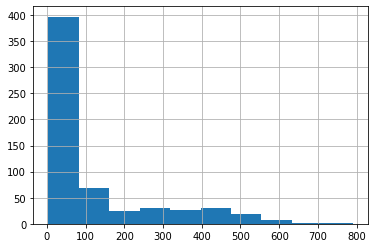

In [8]:
df.groupby('id').size().hist()

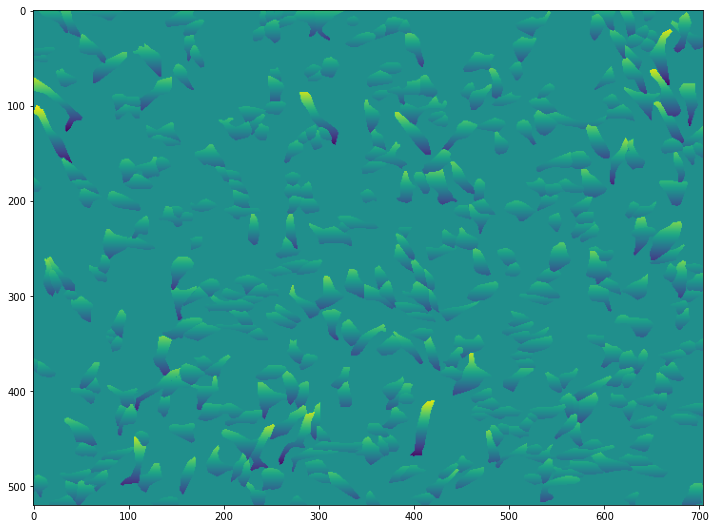

In [50]:
plt.figure(figsize = (12,12))
plt.imshow(tot_mask[:,:,0])
plt.show()

In [51]:
pos = np.stack([
    np.broadcast_to(np.arange(width),(height,width)),
    np.broadcast_to(np.arange(height),(width,height)).T,
    ],axis=-1)

In [56]:
pos[:,:,1]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [517, 517, 517, ..., 517, 517, 517],
       [518, 518, 518, ..., 518, 518, 518],
       [519, 519, 519, ..., 519, 519, 519]])

In [59]:
tocluster = tot_mask[:,:,0:2]+pos
tocluster = tocluster*np.expand_dims(tot_mask[:,:,2],-1)
tocluster = tocluster.reshape((-1,2))

In [92]:
original = cv2.imread('./data/train/{}.png'.format(group['id'][0]))

'0030fd0e6378'

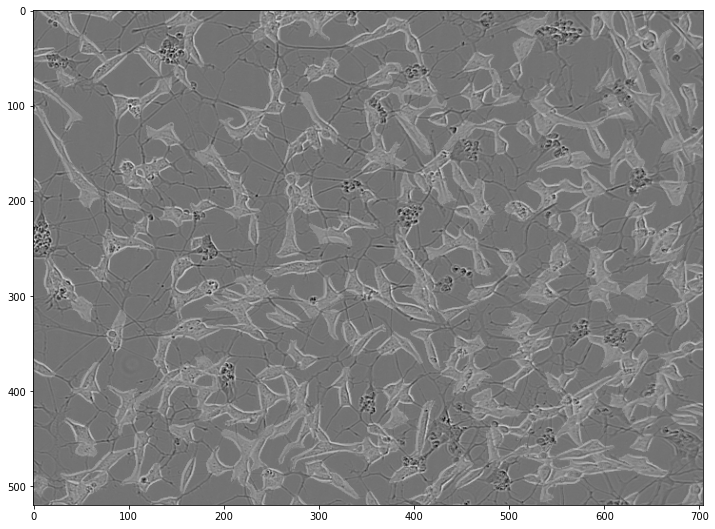

In [93]:
original = cv2.imread('./data/train/{}.png'.format(group['id'][0]))
bella = cv2.cvtColor(255*tot_mask[:,:,2].astype(np.uint8), cv2.COLOR_GRAY2BGR)
original = cv2.addWeighted(original,0.9,bella,0.1,0)

plt.figure(figsize = (12,12))
plt.imshow(original)
plt.show()

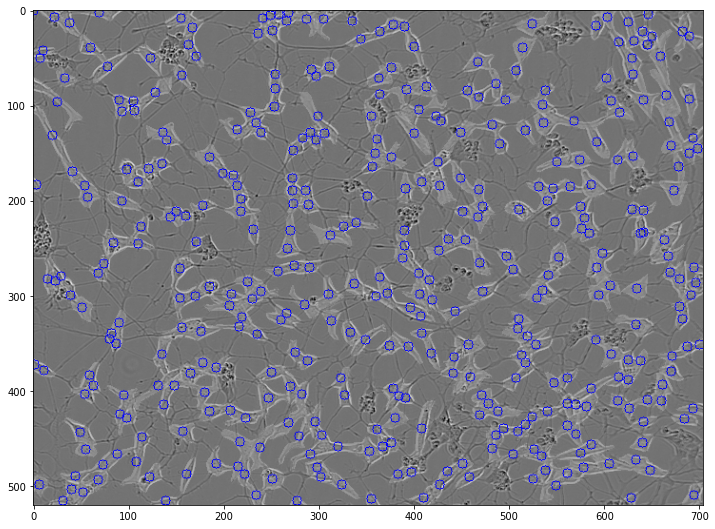

In [94]:
#original = cv2.imread('./data/train/{}.png'.format(group['id'][0]))
centriint = tocluster.astype(int)
for x,y in centriint:
    cv2.circle(original, (x,y), 5, (0,0,255))
plt.figure(figsize = (12,12))
plt.imshow(original)
plt.show()

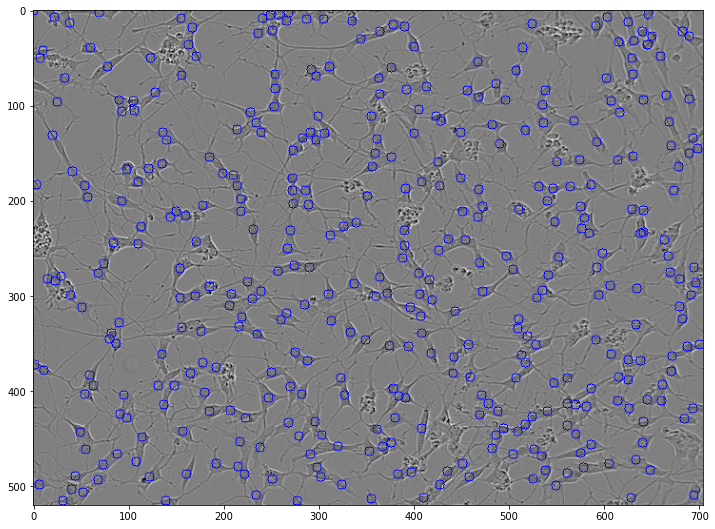

In [85]:
plt.figure(figsize = (12,12))
plt.imshow(original)
plt.show()

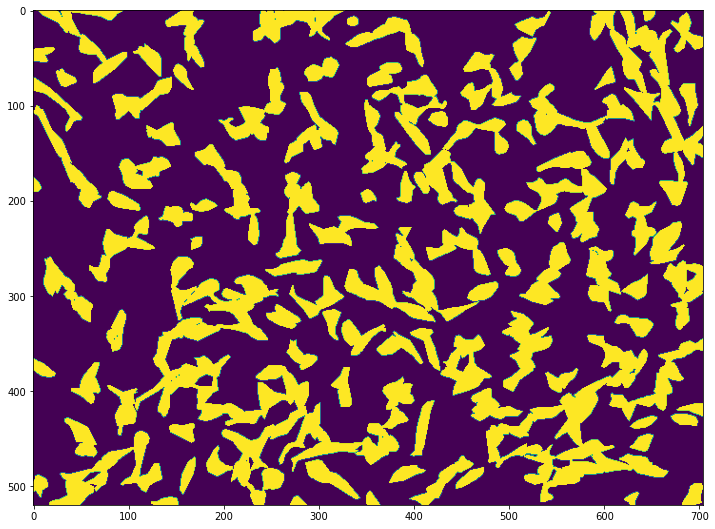

In [86]:
plt.figure(figsize = (12,12))
plt.imshow(tot_mask[:,:,2])
plt.show()

In [84]:
cv2.imshow('original',original)
cv2.waitKey()
cv2.destroyAllWindows()

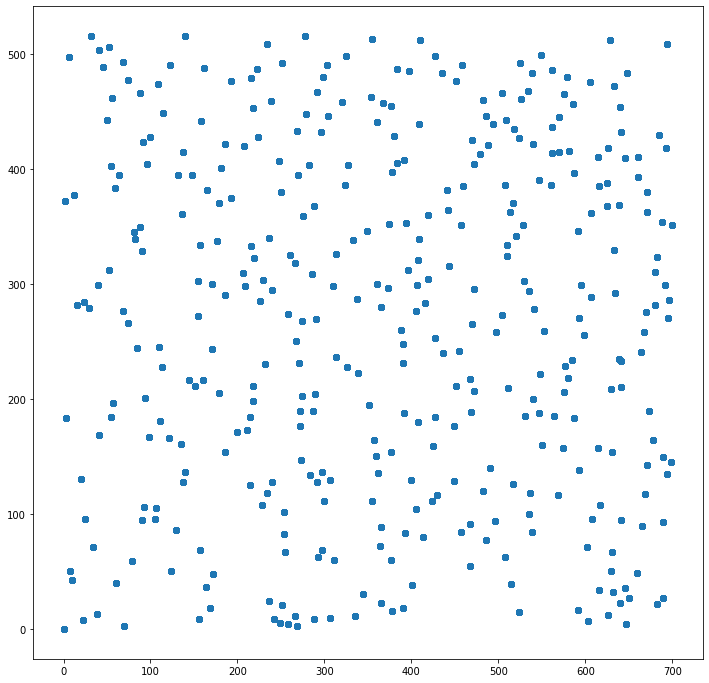

In [60]:
plt.figure(figsize = (12,12))
plt.scatter(tocluster[:,0],tocluster[:,1])
plt.show()

In [69]:
group.count()

id                   395
annotation           395
width                395
height               395
cell_type            395
plate_time           395
sample_date          395
sample_id            395
elapsed_timedelta    395
dtype: int64

In [72]:
np.unique(tocluster.round().astype(int)).shape

(466,)

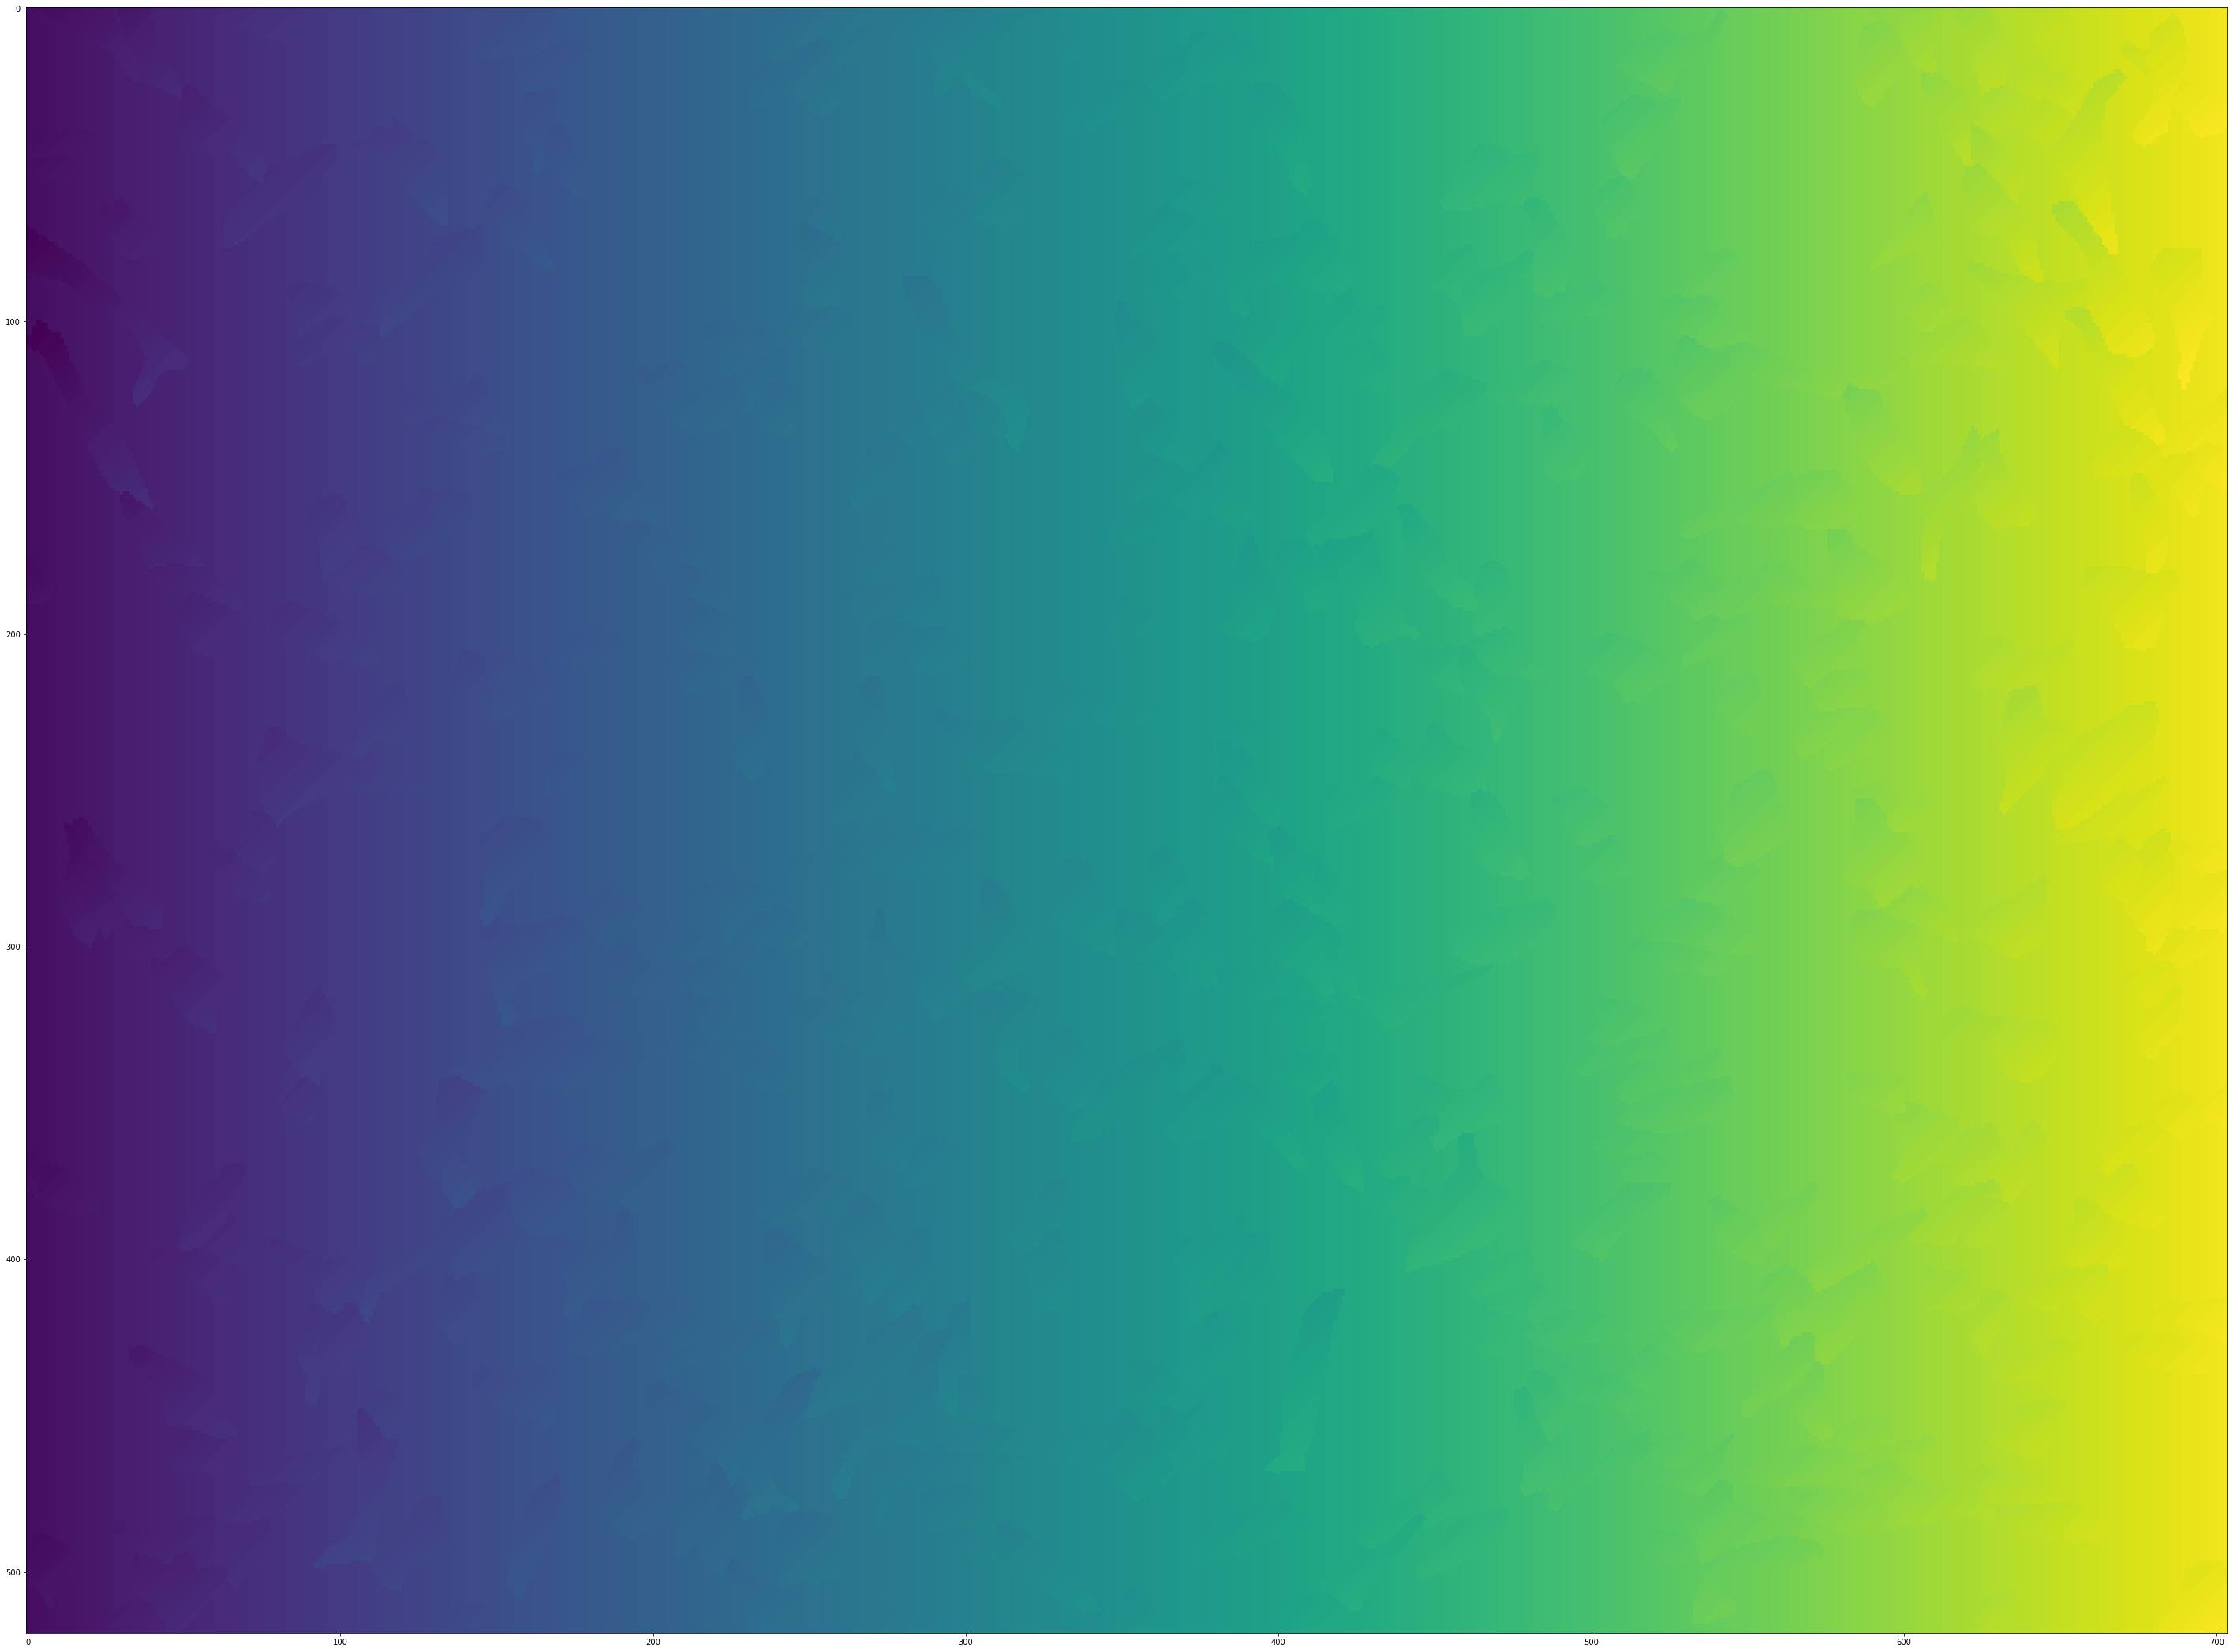

In [41]:
plt.figure(figsize = (50,50))
plt.imshow((tot_mask[:,:,0:2]+pos)[:,:,0])
plt.show()

In [64]:
res = {}
for idgroup, group in df.groupby('id'):
    height = 520
    width = 704
    #if group['cell_type'].unique()[0] != 'cort':
    #    continue
    mask = np.zeros((height*width),dtype=np.uint8)
    for _, row in group.iterrows():
        annotation = np.asarray(list(map(int,row['annotation'].split()))).reshape((-1,2))
        for start, length in annotation:
            mask[start:start+length] += 1
    for v in np.unique(mask):
        if v == 0:
            continue
        if v not in res:
            res[v] = 0
        res[v] += np.count_nonzero(mask == v)

[(i,100*v/sum(res.values())) for i,v in res.items()]

[(1, 97.54449989609081),
 (2, 2.4339493629322617),
 (3, 0.01930417180592632),
 (4, 0.002177840477437616),
 (5, 6.872869356805098e-05)]

In [59]:
df['cell_type'].unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

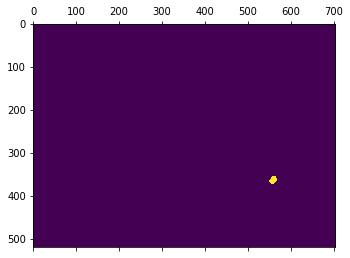

In [69]:
plt.matshow(single_mask)

In [27]:
class CustomImageDataset(torch.utils.data.Dataset):
    @staticmethod
    def annotation_to_mask(annotation, width, height):
        mask = np.zeros((height*width),dtype=bool)
        annotation = np.asarray(list(map(int,annotation.split()))).reshape((-1,2))
        for start, length in annotation:
            mask[start:start+length] = 1
        return mask.reshape((height,width))
        
    def __init__(self):
        
        self.df = pd.read_csv('./data/train.csv')
        f = dict.fromkeys(self.df, 'unique')
        f['annotation'] = [' '.join,'count']
        masks = []
        inputs = []
        for _, instance in self.df.groupby('id').agg(f).iterrows():
            if instance['cell_type']['unique'][0] != 'astro':
                continue
            assert (instance.drop('annotation').apply(len) == 1).all()
            annotation = instance['annotation']['join']
            width = instance['width']['unique'][0]
            height = instance['height']['unique'][0]
            masks.append(CustomImageDataset.annotation_to_mask(annotation, width, height))
            inputs.append(plt.imread('data/train/{}.png'.format(instance['id']['unique'][0])))
        
        assert len(set([m.shape for m in masks])) == 1
        assert len(set([m.shape for m in inputs])) == 1

        self.masks = torch.Tensor(np.array(masks)).cuda().unsqueeze(1).cuda()
        self.inputs = torch.Tensor(np.array(inputs)).cuda().unsqueeze(1).cuda()

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        return self.inputs[idx], self.masks[idx]

In [28]:
train_dataset = CustomImageDataset()

In [26]:
train_dataset.df['cell_type'].unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

In [29]:
class RotationalEquivariantCNN(nn.Module):
  @staticmethod
  def symmetrize(T):
    return (T+torch.rot90(T,1,[-2,-1])+torch.rot90(T,2,[-2,-1])+torch.rot90(T,3,[-2,-1]))/4

  def __init__(self):
    super(RotationalEquivariantCNN, self).__init__()
    self.conv1 = nn.Conv2d(1,4,3, padding='same')
    self.conv2 = nn.Conv2d(4,4,3, padding='same')
    self.conv3 = nn.Conv2d(4,4,3, padding='same')
    self.conv4 = nn.Conv2d(4,1,3, padding='same')

    

    #for c in [self.conv1, self.conv2, self.conv3, self.conv4]:
    #  c.weight = nn.Parameter(RotationalEquivariantCNN.symmetrize(c.weight.detach()))
    #  c.weight.register_hook(RotationalEquivariantCNN.symmetrize)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = torch.sigmoid(self.conv4(x))
    return x

model = RotationalEquivariantCNN().cuda()

In [30]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for t in range(20):
  cumulative_loss = 0
  for _, (inputs, masks) in enumerate(train_dataloader):
    y_pred = model(inputs)
    loss = criterion(y_pred, masks)
    cumulative_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(t, cumulative_loss)

0 1.1939091384410858
1 1.0652766078710556
2 0.9257775694131851
3 0.8215810507535934
4 0.7830657064914703
5 0.7858309894800186
6 0.7906766384840012
7 0.7850681841373444
8 0.7800842970609665
9 0.7818491458892822
10 0.7802620679140091
11 0.7804889678955078
12 0.7799850255250931
13 0.77974933385849
14 0.7799526304006577
15 0.7798788994550705
16 0.7798646241426468
17 0.7797814458608627
18 0.7797716706991196
19 0.7798120379447937


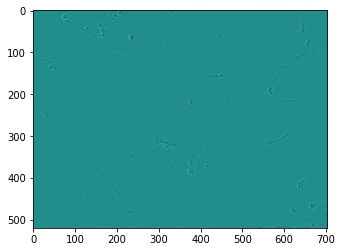

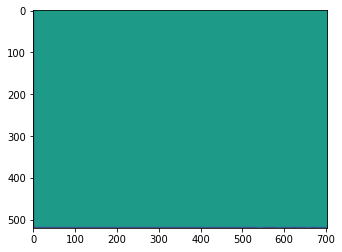

In [31]:
import glob
test_dataset = torch.Tensor(np.array(list(map(plt.imread, glob.glob('data/test/*.png'))))).unsqueeze(1).cuda()
test_out = model(test_dataset)
plt.imshow(test_dataset[0,0].cpu().detach())
plt.show()
plt.imshow(test_out[0,0].cpu().detach())
plt.show()

In [ ]:
#OLD

import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageRotationalEquivariantConv2d(nn.Module):
  def __init__(self, kernel_size):
    super(ImageRotationalEquivariantConv2d, self).__init__()
    self.kernel_size = kernel_size
    weight = torch.rand((1,1,kernel_size,kernel_size))
    self.weight = nn.Parameter(weight)
  
  def forward(self, x):
    augmented_weight = torch.cat([torch.roll(torch.rot90(self.weight,r,[-2,-1]),-r,1) for r in range(0,4)])
    return F.conv2d(x, augmented_weight)